<a href="https://www.kaggle.com/code/jfjerin/densenet201-cse366?scriptVersionId=279156285" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/106_cyt01.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/094_cyt02.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/001_cyt08.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/019_nuc09.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/045_nuc02.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/096_nuc08.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/042_nuc01.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/034_nuc05.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/041_nuc05.dat
/kaggle/input/cervical-cancer-largest-dataset-sipakmed/im_Parabasal/im_Parabasal/096_nuc07.dat
/kaggle/input/cervical-cancer-largest-dataset-sipa

# **Imports and Configuration**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import os
import time
import numpy as np
import pandas as pd # Added for DataFrame manipulation
import matplotlib.pyplot as plt
import seaborn as sns # Used for Confusion Matrix visualization

from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc, classification_report # Added classification_report
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

# --- Configuration ---
data_dir = '/kaggle/input/cervical-cancer-largest-dataset-sipakmed'
train_batch_size = 32
val_test_batch_size = 32
num_workers = 2
num_epochs = 10
learning_rate = 0.001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


# ****Custom Dataset Classes and Transformations****

In [3]:
class CervicalDataset(Dataset):
    def __init__(self, root_dir, transform=None, split_type='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.split_type = split_type
        self.image_paths = []
        self.labels = []
        self.label_map = {}

        print(f"Initializing CervicalDataset for split '{split_type}' from root_dir: {root_dir}")

        top_level_items = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        found_images_count = 0

        if not top_level_items:
             # Add logic for error handling/inference based on your environment
             pass

        for top_item in top_level_items:
            first_level_path = os.path.join(root_dir, top_item)
            nested_class_path = os.path.join(first_level_path, top_item)
            cropped_folder_path = os.path.join(nested_class_path, 'CROPPED')

            if os.path.isdir(cropped_folder_path):
                # print(f"Found CROPPED folder for class '{top_item}' at: {cropped_folder_path}")
                for img_name in os.listdir(cropped_folder_path):
                    if img_name.lower().endswith('.bmp'):
                        img_path = os.path.join(cropped_folder_path, img_name)
                        self.image_paths.append(img_path)
                        self.labels.append(top_item)
                        found_images_count += 1
            else:
                direct_cropped_path = os.path.join(first_level_path, 'CROPPED')
                if os.path.isdir(direct_cropped_path):
                    # print(f"WARNING: Found CROPPED directly under {first_level_path} (no nested class folder).")
                    for img_name in os.listdir(direct_cropped_path):
                        if img_name.lower().endswith('.bmp'):
                            img_path = os.path.join(direct_cropped_path, img_name)
                            self.image_paths.append(img_path)
                            self.labels.append(top_item)
                            found_images_count += 1

        if found_images_count == 0:
            raise ValueError(f"No .bmp images found in: {root_dir}.")

        # print(f"Total images found for split '{split_type}': {len(self.image_paths)}")

        unique_labels = sorted(list(set(self.labels)))
        self.label_map = {label: i for i, label in enumerate(unique_labels)}
        self.int_labels = [self.label_map[label] for label in self.labels]
        self.num_classes = len(self.label_map)

        print(f"Detected classes: {unique_labels}")
        print(f"Number of classes: {self.num_classes}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.int_labels[idx]
        return image, label

# --- Custom Dataset Class 2: Handles Pre-Split Data ---
class SplitDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels # Already integer labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label

# --- Transformations ---
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet stats
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# **Data Loading and Split (Using DataFrame)**

In [4]:
# Check data directory
print(f"\nAttempting to load data from: {data_dir}")
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"The specified data_dir does not exist: {data_dir}. Please check the path.")

# Create a "master" dataset to get all paths and labels first
master_dataset = CervicalDataset(root_dir=data_dir, transform=None, split_type='master')
total_class = master_dataset.num_classes # Renamed for consistency with target format
class_names = list(master_dataset.label_map.keys())

print(f"\nMaster dataset size: {len(master_dataset)} images.")
print(f"Number of classes detected (total_class): {total_class}")

# Create DataFrame for paths and labels
df = pd.DataFrame({
    'file_path': master_dataset.image_paths,
    'label': master_dataset.int_labels # Using int labels for splitting
})

# Perform stratified train/validation/test split (70:15:15)
train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df['label'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df['label'], random_state=42
)

# Extract paths and labels for datasets
train_paths, train_labels = train_df['file_path'].tolist(), train_df['label'].tolist()
val_paths, val_labels = val_df['file_path'].tolist(), val_df['label'].tolist()
test_paths, test_labels = test_df['file_path'].tolist(), test_df['label'].tolist()

print(f"Dataset split sizes: Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

# Create dataset instances for each split with their specific transforms
train_dataset = SplitDataset(train_paths, train_labels, data_transforms['train'])
val_dataset = SplitDataset(val_paths, val_labels, data_transforms['val'])
test_dataset = SplitDataset(test_paths, test_labels, data_transforms['test'])

# Create DataLoaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=num_workers),
    'val': DataLoader(val_dataset, batch_size=val_test_batch_size, shuffle=False, num_workers=num_workers),
    'test': DataLoader(test_dataset, batch_size=val_test_batch_size, shuffle=False, num_workers=num_workers),
}

print("\nDataLoaders created successfully.")
print(f"Train Dataset: {len(train_dataset)} images")
print(f"Test DataLoader batches: {len(dataloaders['test'])}")


Attempting to load data from: /kaggle/input/cervical-cancer-largest-dataset-sipakmed
Initializing CervicalDataset for split 'master' from root_dir: /kaggle/input/cervical-cancer-largest-dataset-sipakmed
Detected classes: ['im_Dyskeratotic', 'im_Koilocytotic', 'im_Metaplastic', 'im_Parabasal', 'im_Superficial-Intermediate']
Number of classes: 5

Master dataset size: 4049 images.
Number of classes detected (total_class): 5
Dataset split sizes: Train: 2834, Val: 607, Test: 608

DataLoaders created successfully.
Train Dataset: 2834 images
Test DataLoader batches: 19


# **Neural Network (DenseNet201)**

In [5]:
# Load pre-trained DenseNet201
model_ft = models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1)
print("Loaded pre-trained DenseNet201 model.")

# Freeze initial layers
for param in model_ft.parameters():
    param.requires_grad = False
print("Frozen initial layers of DenseNet201.")

# Modify classification head
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, total_class) # Use total_class
print(f"Replaced classifier head with output for {total_class} classes.")

model_ft = model_ft.to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
# Optimize only the parameters of the newly added classification head
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=learning_rate)
print(f"Model initialized on {device}.")

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 167MB/s]


Loaded pre-trained DenseNet201 model.
Frozen initial layers of DenseNet201.
Replaced classifier head with output for 5 classes.
Model initialized on cuda:0.


# **Training and Evaluation Helper Functions**

In [6]:
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=10):
    since = time.time()
    best_acc = 0.0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Placeholder for best model weights
    best_model_wts = model.state_dict()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies

def evaluate_model(model, dataloader, device, class_names, train_losses, train_accuracies, val_losses, val_accuracies):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    end_time = time.time()
    test_time = end_time - start_time

    # --- Calculate Metrics ---
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # ROC Curve and AUC (One-vs-Rest for multi-class)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    binarized_labels = label_binarize(all_labels, classes=range(len(class_names)))
    
    for i in range(len(class_names)):
        if np.sum(binarized_labels[:, i]) < 2 or len(np.unique(binarized_labels[:, i])) < 2:
            fpr[i], tpr[i], _ = [0], [0], [0]
            roc_auc[i] = np.nan
            continue
        
        fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], np.array(all_probs)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Micro-average ROC curve and AUC
    fpr_micro, tpr_micro, _ = roc_curve(binarized_labels.ravel(), np.array(all_probs).ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    # Macro-average ROC curve and AUC
    valid_classes = [i for i in range(len(class_names)) if not np.isnan(roc_auc[i])]
    if valid_classes:
        all_fpr = np.unique(np.concatenate([fpr[i] for i in valid_classes]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in valid_classes:
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= len(valid_classes)
        fpr_macro = all_fpr
        tpr_macro = mean_tpr
        roc_auc_macro = auc(fpr_macro, tpr_macro)
    else:
        fpr_macro, tpr_macro, roc_auc_macro = None, None, np.nan

    # --- Visualizations ---
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig('confusion_matrix.png') # Save plot for notebook
    plt.show()

    # Plotting training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy')
    plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('training_history.png') # Save plot for notebook
    plt.show()

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})', color='deeppink', linestyle=':', linewidth=4)
    if not np.isnan(roc_auc_macro):
        plt.plot(fpr_macro, tpr_macro, label=f'Macro-average ROC (AUC = {roc_auc_macro:.2f})', color='navy', linestyle=':', linewidth=4)
    
    cmap = plt.colormaps['jet']
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_names))]

    for i, color in zip(range(len(class_names)), colors):
        if not np.isnan(roc_auc[i]):
            plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
        
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.savefig('roc_curves.png') # Save plot for notebook
    plt.show()

    return all_labels, all_preds, cm, test_time

# --- Helper function for per-class accuracy ---
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_acc = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_acc

# **Training Execution**

In [7]:
print("Starting Cervical Cancer Classification Training with DenseNet201...")

# Train the model
trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model_ft, criterion, optimizer_ft, dataloaders, device, num_epochs=num_epochs
)

print("\nModel Training Complete.")

Starting Cervical Cancer Classification Training with DenseNet201...
Epoch 1/10
----------
train Loss: 0.8941 Acc: 0.6867
val Loss: 0.4816 Acc: 0.8418

Epoch 2/10
----------
train Loss: 0.5539 Acc: 0.8130
val Loss: 0.3650 Acc: 0.8699

Epoch 3/10
----------
train Loss: 0.4489 Acc: 0.8419
val Loss: 0.2952 Acc: 0.8995

Epoch 4/10
----------
train Loss: 0.4309 Acc: 0.8451
val Loss: 0.2954 Acc: 0.8896

Epoch 5/10
----------
train Loss: 0.4183 Acc: 0.8497
val Loss: 0.2635 Acc: 0.9061

Epoch 6/10
----------
train Loss: 0.3947 Acc: 0.8606
val Loss: 0.2370 Acc: 0.9209

Epoch 7/10
----------
train Loss: 0.3904 Acc: 0.8550
val Loss: 0.2328 Acc: 0.9143

Epoch 8/10
----------
train Loss: 0.3723 Acc: 0.8613
val Loss: 0.2195 Acc: 0.9176

Epoch 9/10
----------
train Loss: 0.3711 Acc: 0.8634
val Loss: 0.2653 Acc: 0.8995

Epoch 10/10
----------
train Loss: 0.3499 Acc: 0.8723
val Loss: 0.2083 Acc: 0.9143

Training complete in 3m 19s
Best val Acc: 0.9209

Model Training Complete.


# **Final Test Evaluation and Visualization**


--- Starting Final Evaluation on Test Set ---


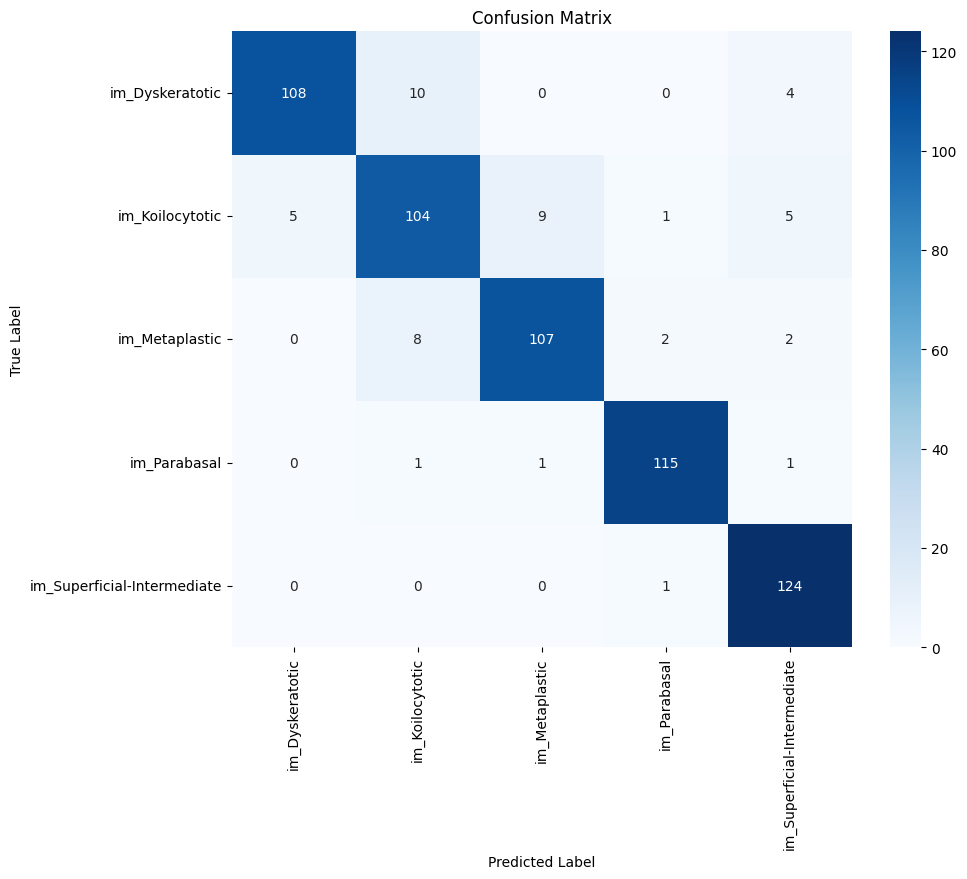

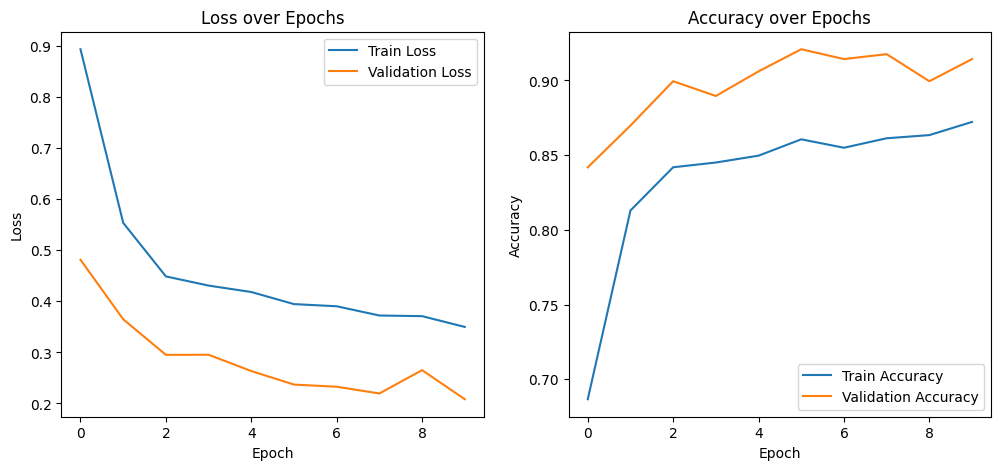

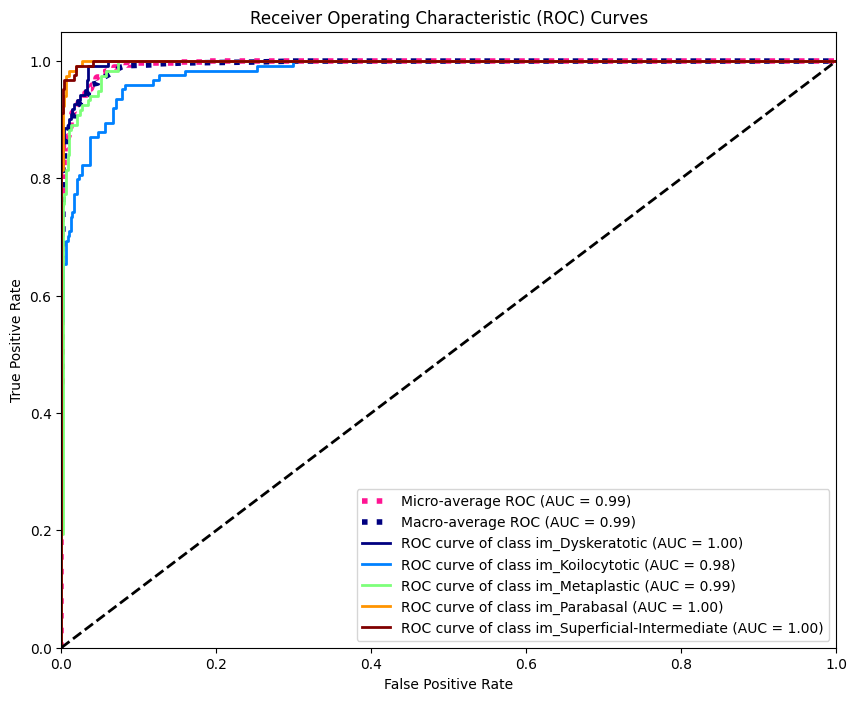


Test Inference Time: 3.75 seconds

Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.96      0.89      0.92       122
            im_Koilocytotic       0.85      0.84      0.84       124
             im_Metaplastic       0.91      0.90      0.91       119
               im_Parabasal       0.97      0.97      0.97       118
im_Superficial-Intermediate       0.91      0.99      0.95       125

                   accuracy                           0.92       608
                  macro avg       0.92      0.92      0.92       608
               weighted avg       0.92      0.92      0.92       608

Class 'im_Dyskeratotic' Accuracy: 0.885
Class 'im_Koilocytotic' Accuracy: 0.839
Class 'im_Metaplastic' Accuracy: 0.899
Class 'im_Parabasal' Accuracy: 0.975
Class 'im_Superficial-Intermediate' Accuracy: 0.992

--- Displaying a sample image with its predicted label ---


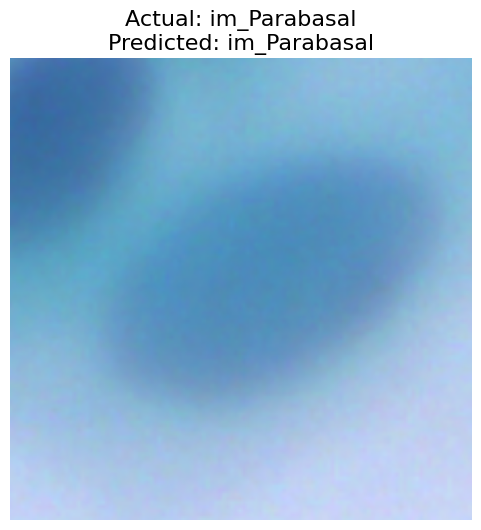

In [8]:
print("\n--- Starting Final Evaluation on Test Set ---")

y_true, y_pred, test_cm, test_time = evaluate_model(
    trained_model,
    dataloaders['test'],
    device,
    class_names,
    train_losses,
    train_accuracies,
    val_losses,
    val_accuracies
)

# --- Print Final Reports ---
print(f"\nTest Inference Time: {test_time:.2f} seconds")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

class_acc = class_accuracy(trained_model, dataloaders['test'], total_class)
for i, name in enumerate(class_names):
    print(f"Class '{name}' Accuracy: {class_acc[i]:.3f}")


# --- Displaying a sample image with its predicted label ---
print("\n--- Displaying a sample image with its predicted label ---")

sample_inputs, sample_labels = next(iter(dataloaders['test']))
sample_input = sample_inputs[0].unsqueeze(0).to(device)
actual_label_idx = sample_labels[0].item()

trained_model.eval()
with torch.no_grad():
    output = trained_model(sample_input)
    _, predicted_class_idx = torch.max(output, 1)

predicted_label_idx = predicted_class_idx.item()

# Denormalize image for display
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
display_image = inv_normalize(sample_inputs[0]).permute(1, 2, 0).cpu().numpy()
display_image = np.clip(display_image, 0, 1)

plt.figure(figsize=(6, 6))
plt.imshow(display_image)
plt.title(f"Actual: {class_names[actual_label_idx]}\nPredicted: {class_names[predicted_label_idx]}", fontsize=16)
plt.axis('off')
plt.savefig('sample_prediction.png')
plt.show()